In [1]:
import numpy as np
import scipy.sparse as ss
import random
import pandas as pd

from corextopic import corextopic as ct
from corextopic import vis_topic as vt # jupyter notebooks will complain matplotlib is being loaded twice

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

import gensim
from sklearn.datasets import fetch_20newsgroups
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.corpora import Dictionary

import os
import numpy as np
import pandas as pd
import pickle
import pyLDAvis
import pyLDAvis.gensim_models


from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter('ignore')

/Users/muruwu/opt/anaconda3/lib/python3.8/site-packages/gensim/corpora/dictionary.py:11: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping, defaultdict
/Users/muruwu/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
/Users/muruwu/opt/anaconda3/lib/python3.8/site-packages/gensim/models/doc2vec.py:73: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import namedtuple, defaultdict, Iterable


There are 10372 documents.
95% of the documents are below: 605 words.
Solid green line indicates median, dotted red line indicates 95 percentile. Outliers may be cropped.
19039
In the dataset there are 19475 textual documents
And this is the first one:
 skip to main content search upload sign up log in books video audio software imagesabout blog projects help donate contact jobs volunteer people search metadata search text contents search
There are 19475 documents.
95% of the documents are below: 53 words.
Solid green line indicates median, dotted red line indicates 95 percentile. Outliers may be cropped.


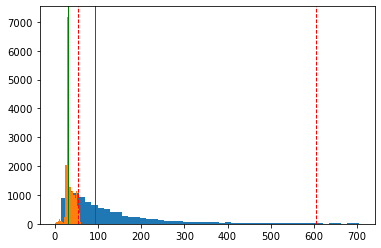

In [3]:
#just for convenience of outputting all files to this specific project folder for this model
os.chdir('Corex_w2v/Amanda_model')

import matplotlib.pyplot as plt
def describe_training_documents(list_of_docs):
    print('There are',len(list_of_docs),'documents.')
    document_lengths = list(map(lambda x: len(x.split()),list_of_docs))
    percentile_50 = int(np.percentile(document_lengths,50))
    percentile_95 = int(np.percentile(document_lengths,95))
    print('95% of the documents are below:',percentile_95,'words.')
    plt.axvline(percentile_50, lw=1, color='g')
    plt.axvline(percentile_95, lw=1, color='r', linestyle='--')
    _ = plt.hist(document_lengths, bins=50, range=(0,percentile_95+100))
    print('Solid green line indicates median, dotted red line indicates 95 percentile. Outliers may be cropped.')

def flatten_list(l):
    return [item for sublist in l for item in sublist]

def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

def chop(text):
    temp=text.split()
    num=len(temp)//30
    new=[]
    for i in range(num):
        if i !=num-1:
            a=temp[30*i:30*(i+1)]
        else:
            a=temp[30*(num-1):]
        new.append(" ".join(a))
    return new

# Get 20 newsgroups data
newsgroups = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
documents_train = list(np.load('../../training/train.npy')) # historical materials 4451 documents
documents_train2 = list(np.load('../../training/train2.npy'))   # census bureau 4226 documents
df_occsc = pd.read_csv('../../OCC_pairs.csv').rename(columns={'OCC_DES':'Full Occupation'})
assert(df_occsc['Full Occupation'].nunique() == len(df_occsc))
occ_list = list(set(list(df_occsc['Full Occupation'])))

occ_list2=[]
#eliminate confusing words in the occ_list
confusing_words=['occupation','occupations','Occupations','men']
for occ in occ_list:
    a=occ.split(' ')
    for word in confusing_words:
        if word in a:
            a.remove(word)
    occ_list2.append(' '.join(a))
occ_list=occ_list2

with open("../../training/nyt_text_modified.txt",'r') as f:
    nyt_text2=[]
    lines=f.readlines()
    for line in lines:
        nyt_text2.append(line)

# Q: why select only 4000 

twenty_news=[]
for news in newsgroups.data:
    if len(news.split())>15:
        twenty_news.append(news)
describe_training_documents(twenty_news)
random.seed(10)
twenty_news=random.sample(twenty_news,4000)

# but fit the model with the training dataset
# corex model requires them to be the same shape 
documents = []
documents.extend(documents_train)
documents.extend(documents_train2)
documents.extend(nyt_text2)

documents_mod=[]
for doc in documents:
    chopped=chop(doc)
    for a in chopped:
        tokens=simple_preprocess(a)
        new_tokens=[]
        for word in tokens:
            if not word.isdigit():
                new_tokens.append(word)
        new=" ".join(new_tokens)
        documents_mod.append(new)

document_total=documents_mod[:]
document_total.extend(occ_list)
print(len(documents_mod))
print("In the dataset there are", len(document_total), "textual documents")
print("And this is the first one:\n", documents_mod[0])

describe_training_documents(document_total)

***
below are merely test functions
***

# Q: but this isn't successfully parsed for some reason

In [6]:
len_arr=np.asarray([len(item.split(' ')) for item in document_total])
document_total[np.argmax(len_arr)]

'second thoughts on voluntary code making by american industry do not reveal very clear cut situation the wage hour price structure under the nra codes is it is presumed that wages and working hours can be embodied in voluntary codes but where is the line of demarcation when it comes to voluntary stabilization of prices when the anti trust laws are considered'

# Q: And there're documents with non-English chars 
we can clean with basic regrex maybe

In [7]:
print(max(document_total))

穏raphic division the proportion was higher for the foreignborn white mafos than for the males of either of the nath積 white classes and in ach of the geographic dhisions except


Text(0, 0.5, 'doc_length')

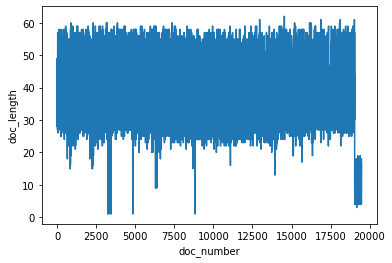

In [8]:
plt.figure(0)
plt.plot(len_arr)
plt.xlabel('doc_number')
plt.ylabel('doc_length')

***
test codes end
***

## Transform data into a sparse matrix¶

# count vectorizer 
(filtering out: useless phrases like 'aa','ab' with token_pattern, & min_df)

In [9]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=2,
# minimum reqd occurences of a word 
                             stop_words='english',             
# remove stop words
                             lowercase=True,                   
# convert all words to lowercase
                             token_pattern='[a-zA-Z]{3,}',  
# num chars > 3
                             max_features=20000,             
# max number of uniq words    
                            )
data_vectorized = vectorizer.fit_transform(document_total)

In [10]:
doc_word = vectorizer.fit_transform(document_total)
doc_word = ss.csr_matrix(doc_word)
fixed_vocabulary=vectorizer.vocabulary_
words = list(np.asarray(vectorizer.get_feature_names()))

# Q: try find frequency of fixed voc

In [12]:
topic_num=60
topic_model = ct.Corex(n_hidden=topic_num, words=words, eps=1e-2,max_iter=100, verbose=False, seed=1)
topic_model.fit(doc_word[:len(documents_mod)], words=words)

In [13]:
# Print a single topic from CorEx topic model
topic_model.get_topics(topic=20, n_words=10)

[('american', 0.03570231998520268, 1.0),
 ('war', 0.02542871871758147, 1.0),
 ('world', 0.018345561285183373, 1.0),
 ('country', 0.012495536049215904, 1.0),
 ('society', 0.01144207092559819, 1.0),
 ('says', 0.010938772561319636, 1.0),
 ('movement', 0.010286919155662554, 1.0),
 ('action', 0.008177295178333346, 1.0),
 ('street', 0.00756682912906009, 1.0),
 ('federation', 0.007255233062166837, 1.0)]

I aded '~' here since the original function also prints out words whose absence is significant to a topic (they have s<0), so here, I added ~ before them to distinguish these absent words from the other topic words

For details, you can check here: https://github.com/gregversteeg/corex_topic#running-the-corex-topic-model


In [ ]:
# Print all topics from the CorEx topic model

topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    # w: word, mi: mutual information, s: sign
    topic_words,_,_ = zip(*[(w,mi,s) if s > 0 else ('~'+w,mi,s) for w,mi,s in topic])
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

In [15]:
results=topic_model.predict(doc_word[len(documents_mod):])
results.shape

(436, 60)

## Total Corelation and Model Selection

In [16]:
topic_model.tc 

5.365385775407672

In [17]:
tc_lst=[[i,v] for i,v in enumerate(topic_model.tcs)]
tc_df=pd.DataFrame(tc_lst,columns=['topic','tc'])

In [18]:
import altair as alt
chart=alt.Chart(tc_df).mark_bar().encode(x='topic',y='tc',tooltip=tc_df.columns.tolist()).properties(
    width=800)
chart

alt.Chart(...)

If you hover over, you can see that topic 6 is the cut-off boundary

In [19]:
chart.save('Tc_distr_v1.html')

## Pointwise Document TC

We can decompose total correlation further. The topic correlation is the average of the pointwise total correlations for each individual document. The pointwise total correlations can be accessed through log_z.

In [20]:
topic_model.log_z # n_docs x k_topics

array([[ 7.09779218e-01,  4.20599071e-01,  3.71959114e-01, ...,
         4.46974806e-03,  3.36120146e-03,  3.41164400e-03],
       [ 7.09779218e-01, -5.95204711e-01,  3.71959114e-01, ...,
        -4.23488360e-03,  3.68688331e-03,  3.91125372e-03],
       [ 7.09779218e-01,  1.99244834e+00,  3.71959114e-01, ...,
        -4.31722060e-02,  2.43334735e-03,  3.86500588e-03],
       ...,
       [ 7.09779218e-01,  4.20599071e-01, -2.55576444e-01, ...,
        -1.06394289e-03,  2.55240972e-03,  6.63173132e-04],
       [ 7.09779218e-01, -5.95204711e-01,  3.71959114e-01, ...,
        -7.11688698e-04,  3.52173435e-03,  2.08494015e-03],
       [-1.84844036e+00,  4.20599071e-01,  3.71959114e-01, ...,
        -9.75686014e-04,  2.93997932e-03,  1.96996661e-03]])

In [21]:
print(np.mean(topic_model.log_z, axis=0)) #The pointwise total correlations in log_z represent the correlations within an individual document explained by a particular topic. These correlations have been used to measure how "surprising" documents are with respect to given topics
print(topic_model.tcs)

[0.66434364 0.55975493 0.46578686 0.32116143 0.30054004 0.27632966
 0.25292519 0.24396952 0.17464487 0.17271964 0.14952969 0.13937257
 0.13701273 0.12396385 0.0808805  0.08039454 0.07430696 0.07212932
 0.06986517 0.06328751 0.0590927  0.05695351 0.05181967 0.05154655
 0.05010663 0.049012   0.04184238 0.04123271 0.04106111 0.03852416
 0.03625815 0.03323562 0.03219579 0.02880976 0.02870121 0.02359333
 0.02348045 0.01698812 0.01678462 0.01648695 0.01427115 0.01267054
 0.01255521 0.01164168 0.01114006 0.01112151 0.01057246 0.0105284
 0.01046922 0.01031129 0.01004515 0.0098701  0.00973535 0.00956798
 0.00923312 0.00916255 0.00826553 0.0080398  0.00796698 0.00757364]
[0.66434364 0.55975493 0.46578686 0.32116143 0.30054004 0.27632966
 0.25292519 0.24396952 0.17464487 0.17271964 0.14952969 0.13937257
 0.13701273 0.12396385 0.0808805  0.08039454 0.07430696 0.07212932
 0.06986517 0.06328751 0.0590927  0.05695351 0.05181967 0.05154655
 0.05010663 0.049012   0.04184238 0.04123271 0.04106111 0.0385

## Introducing Anchoring in the semi-supervised topic mode

CorEx is a discriminative model, whereas LDA is a generative model. This means that while LDA outputs a probability distribution over each document, CorEx instead estimates the probability a document belongs to a topic given that document's words. As a result, the probabilities across topics for a given document do not have to add up to 1. The estimated probabilities of topics for each document can be accessed through log_p_y_given_x or p_y_given_x.

Hierarchical Topic Models The labels attribute gives the binary topic expressions for each document and each topic. We can use this output as input to another CorEx topic model to get latent representations of the topics themselves. This yields a hierarchical CorEx topic model. Like the first layer of the topic model, one can determine the number of latent variables to add in higher layers through examination of the topic TCs.

Anchored CorEx is an extension of CorEx that allows the "anchoring" of words to topics. When anchoring a word to a topic, CorEx is trying to maximize the mutual information between that word and the anchored topic. So, anchoring provides a way to guide the topic model towards specific subsets of words that the user would like to explore.

Anchoring a single set of words to a single topic. This can help promote a topic that did not naturally emerge when running an unsupervised instance of the CorEx topic model. For example, one might anchor words like "snow," "cold," and "avalanche" to a topic if one suspects there should be a snow avalanche topic within a set of disaster relief articles.

Anchoring single sets of words to multiple topics. This can help find different aspects of a topic that may be discussed in several different contexts. For example, one might anchor "protest" to three topics and "riot" to three other topics to understand different framings that arise from tweets about political protests.

Anchoring different sets of words to multiple topics. This can help enforce topic separability if there appear to be chimera topics. For example, one might anchor "mountain," "Bernese," and "dog" to one topic and "mountain," "rocky," and "colorado" to another topic to help separate topics that merge discussion of Bernese Mountain Dogs and the Rocky Mountains.

In [47]:
#to automatically generate anchor words: for each label in a data set, 
#we find the words that have the highest mutual information with the label.
# we took a very simple to automatically generate the anchor words to create a semi-supervised model
anchor_words=[]
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    anchor_words.append(list(topic_words[:3]))
    print('{}: '.format(n) + ','.join(topic_words))

0: products,value,establishments,industry,total,reported,manufacture,statistics,increase,industries
1: fig,piece,inch,cut,mold,pieces,surface,inches,cement,dry
2: wage,earners,cent,age,employed,proportion,females,engaged,gainful,males
3: precinct,transfers,museum,assignments,patrolmen,exhibition,annum,cable,sterling,bills
4: new,york,north,south,jersey,west,central,massachusetts,ohio,east
5: quantity,used,sugar,steel,purchased,iron,milk,fuel,electric,rolling
6: boulle,marquetry,dye,bronze,stock,ebony,packages,louis,amsterdam,pint
7: water,add,hot,boil,boiling,liquid,soda,pan,white,oven
8: today,president,washington,government,federal,department,jan,mrs,nov,commission
9: avenue,police,supreme,oct,act,address,tomorrow,thomas,tonight,vote
10: union,local,members,national,employers,organized,trades,secretary,membership,shops
11: company,market,bank,old,night,july,sales,trading,sept,reserve
12: introduction,borne,mind,estimate,animals,ivory,ornament,compare,decorated,architecture
13: silver

In [48]:
#manually adjust the anchor words based on the observation

anchor_words[0]=['manufacturing','mechanical','industry']
anchor_words[1]=['water','wood','boil']
anchor_words[2]=['workers','organizations','committee']
anchor_words[3]=['furniture','wood','carve','carpenters','workmen'] 
anchor_words[7]=['forgemen','harmmermen']
anchor_words[8]=['market','trade','stock','sales']
anchor_words[11]=['university','institute','education','professional'] 
anchor_words[13]=['forestry','agriculture','husbandry'] 
anchor_words[14]=['electric','power','mechanic','engines'] 
anchor_words[18]=['iron','blacksmiths','steel']
anchor_words[20]=['art','gallery','artists']
anchor_words[26]=['machinery','machinists','apparatus']
anchor_words[31]=['meat','butchers','slaughtering']
anchor_words[32]=['textile','fabrics','clothing','tailors']
anchor_words[37]=['family','house','personal']
anchor_words[38]=['coal','miners']
anchor_words[39]=['court','justice','lawyers','judge']
anchor_words[47]=['household','domestic','house']
anchor_words[49]=['public','school','teachers']
anchor_words[51]=['clerks','shop']
anchor_words[56]=['book','publishing','authors']

# Predict

In [49]:
df_occsc = pd.read_csv('../../OCC_pairs.csv').rename(columns={'OCC_DES':'Full Occupation'})
assert(df_occsc['Full Occupation'].nunique() == len(df_occsc))
occ_original = list(set(list(df_occsc['Full Occupation'])))

In [50]:
def get_predict_result(results):
    pairs=[]
    for i in range(len(results)):
        for j in range(len(results[i])):
            if results[i][j]==True:
                pairs.append([i,j])
    return pairs

#might change the threshold
#get log_p_y_given_x for each doc
def get_predict_proba(results_proba):
    pairs_proba={i:[] for i in range(len(results_proba))}
    #i: document num
    for i in range(len(results_proba)):
        #j: topic num for each doc
        for j in range(len(results_proba[i])):
            #threshold
            if results_proba[i][j] >= 1e-3:
                pairs_proba[i].append((j,results_proba[i][j]))
    return pairs_proba

def count_topics(pairs):
    available={}
    for a,b in pairs:
        if b not in available.keys():
            available[b]=1
        else:
            available[b]+=1
    return available 

def get_topic_content(pairs,topic):
    result=[]
    for a,b in pairs:
        if b == topic:
            result.append(occ_list[a])
    return result 

def get_topic_list(pairs):
    result={}
    for a,b in pairs:
        if b not in result.keys():
            result[b]=[a]
        else:
            result[b].append(a)
    return result

def save_topic(pairs):
    result_dic=get_topic_list(pairs)
    with open("train_result_30.txt",'w') as f:
        for m,n in result_dic.items():
            topic_words,_,_ = zip(*anchored_topic_model.get_topics(topic=m))
            title=str(m)+":"+(','.join(topic_words))
            f.write(title+'\n')
            for file in n:
                occ_title=occ_list[file]
                f.write(occ_title+'\n')
            f.write("\n \n \n")

In [51]:
m1 = ct.Corex(n_hidden=10, words=words)
m1.fit(doc_word[:len(documents_mod)], words=words);
results=m1.transform(doc_word[len(documents_mod):])

In [52]:
results_proba,mutual=m1.transform(doc_word[len(documents_mod):],details=True)

CorEx is a *discriminative* model, whereas LDA is a *generative* model. This means that while LDA outputs a probability distribution over each document, CorEx instead estimates the probability a document belongs to a topic given that document's words. 

As a result, the probabilities across topics for a given document do not have to add up to 1. 

The estimated probabilities of topics for each document can be accessed through **`log_p_y_given_x`** or **`p_y_given_x`**.

The pointwise total correlations in **`log_z`** represent the correlations within an individual document explained by a particular topic. 

These correlations have been used to measure how "surprising" documents are with respect to given topics (see references below).

In [53]:
results=m1.transform(doc_word[len(documents_mod):])

In [88]:
#just an idea of how pairs_proba looks like
results=m1.transform(doc_word[len(documents_mod):])
results_proba,mutual=m1.transform(doc_word[len(documents_mod):],details=True)
pairs=get_predict_result(results)
pairs_proba=get_predict_proba(results_proba)
pairs_proba
clear_output()

NameError: name 'clear_output' is not defined

In [30]:
def train_model(topic_num,anchor_w=anchor_words):
    anchored_topic_model= ct.Corex(n_hidden=topic_num, seed=2)
    anchored_topic_model.fit(doc_word[:len(documents_mod)], words=words, anchors=anchor_w, anchor_strength=10)
    print("-"*12,"topic words","-"*12)
    for n in range(topic_num):
        topic_words,_,_ = zip(*anchored_topic_model.get_topics(topic=n))
        print('{}: '.format(n) + ','.join(topic_words))
    print("-"*12,"print total correlation","-"*12)
    print(anchored_topic_model.tc)
    #predict
    results=anchored_topic_model.predict(doc_word[len(documents_mod):])
    results_proba,mutual_info=anchored_topic_model.predict_proba(doc_word[len(documents_mod):])
    
    pairs=get_predict_result(results)
    pairs_proba=get_predict_proba(results_proba)
    
    has_categorized=[]
    
    #a is the document index, d is the topic number it belongs to
    for a,b in pairs:
        if a not in has_categorized:
            has_categorized.append(a)
    print("-"*12,"occ that have been categorized into certain types","-"*12)
    print(len(has_categorized))

    has_not_categorized=[]
    for i in range(len(occ_original)):
        if i not in has_categorized:
            has_not_categorized.append(occ_original[i])
          
    print("-"*12,"has_not_categorized","-"*12)
    print(has_not_categorized)

    print("-"*12,"corresponding counts of topic","-"*12)
    print(count_topics(pairs))
    
    return anchored_topic_model,pairs,pairs_proba,has_not_categorized

In [31]:
def get_pairs_proba(anchored_model):
    #predict
    results=anchored_topic_model.predict(doc_word[len(documents_mod):])
    results_proba,mutual_info=anchored_topic_model.predict_proba(doc_word[len(documents_mod):])
    
    pairs=get_predict_result(results)
    pairs_proba=get_predict_proba(results_proba)
    
    has_categorized=[]
    
    #a is the document index, d is the topic number it belongs to
    for a,b in pairs:
        if a not in has_categorized:
            has_categorized.append(a)
    print("-"*12,"occ that have been categorized into certain types","-"*12)
    print(len(has_categorized))

    has_not_categorized=[]
    for i in range(len(occ_original)):
        if i not in has_categorized:
            has_not_categorized.append(occ_original[i])
          
    print("-"*12,"has_not_categorized","-"*12)
    print(has_not_categorized)

    print("-"*12,"corresponding counts of topic","-"*12)
    print(count_topics(pairs))
    
    return pairs,pairs_proba,has_not_categorized

In [85]:
anchored_topic_model,pairs,pairs_proba,has_not_categorized =train_model(60,anchor_words[:10])

------------ topic words ------------
0: industry,manufacturing,mechanical,branches,branch,summary,presents,principal,chemical,growth
1: wood,water,boil,add,dry,stain,hot,till,boiling,logwood
2: workers,committee,organizations,garment,organize,amalgamated,jewish,lisa,examined,studied
3: wood,furniture,workmen,carpenters,chairs,carved,decoration,ivory,decorated,carve
4: new,york,north,jersey,carolina,massachusetts,editor,england,mexico,hampshire
5: used,quantity,sugar,fuel,beet,cane,consumed,coal,kinds,molasses
6: boulle,marquetry,dye,style,century,taste,renaissance,designs,louis,design
7: san,newspapers,francisco,periodicals,stage,screen,lady,hollywood,conviction,sort
8: trade,market,stock,sales,exchange,prices,foreign,posted,trading,sterling
9: avenue,police,supreme,today,yesterday,street,court,john,precinct,technology
10: teacher,lesson,lessons,girl,seen,competent,language,discuss,rome,looking
11: acid,sulphuric,skins,hides,nitric,acids,mixed,leather,treated,pipe
12: west,east,old,gr

In [86]:
#save model:
#must have hyperparameter set to "False" to preserve word labels!!
model_name='m1.dat'
anchored_topic_model.save(model_name,False)

In [87]:
import pickle as pkl

#load model:
model_path='m1.dat'
if os.path.exists(model_path):
    print('loaded from old')
    with open(model_path, 'rb') as f:
        anchored_topic_model = pkl.load(f) 
        pairs,pairs_proba,has_not_categorized=get_pairs_proba(anchored_topic_model)
else:
    print('created from old')
    anchored_topic_model,pairs,pairs_proba,has_not_categorized =train_model(60,anchor_words)

loaded from old
------------ occ that have been categorized into certain types ------------
436
------------ has_not_categorized ------------
[]
------------ corresponding counts of topic ------------
{0: 185, 22: 37, 28: 436, 1: 11, 57: 61, 8: 87, 23: 4, 54: 28, 26: 15, 50: 24, 9: 30, 41: 14, 6: 6, 12: 6, 34: 11, 3: 26, 10: 5, 33: 6, 42: 13, 24: 13, 37: 27, 56: 16, 14: 21, 18: 50, 59: 30, 19: 3, 36: 1, 49: 14, 44: 11, 11: 6, 35: 8, 53: 6, 29: 2, 43: 5, 31: 6, 38: 7, 45: 4, 52: 17, 25: 11, 13: 9, 30: 19, 47: 9, 16: 5, 32: 2, 55: 6, 27: 2, 40: 1, 21: 2, 15: 4, 48: 5, 7: 3, 17: 4, 51: 3, 2: 5, 39: 1}


In [82]:
os.getcwd()

'/Users/muruwu/Desktop/nyu/sophomore/2nd_sem/humanities_research/topic_modeling/Coding_files/Corex_w2v/Amanda_model'

In [ ]:
#just an idea of what a topic_helper dictionary looks like
topic_helper

# Score Imputation

## Dictionary formation: {Topic: Score}

In [ ]:
#new
topic_score_dict = {} # key: topic, value: occscore
topic_helper={i:[] for i in range(len(anchored_topic_model.get_topics()))}
#topic_helper: {topic_num:[(score,proba)...]}
for job_num in pairs_proba.keys():
    #job_num: index of each occ despcriction
    topic_prob=pairs_proba[job_num]
    #topic_prob: the list of topcis & prob that an occ belongs to
    #s: sum of weights (prob)
    occ=occ_original[job_num]
    #occ: each original occ description (without being cleaned of confusing words)
    score = list(df_occsc[df_occsc['Full Occupation']==occ]['OCCSCORE'])[0]
    #debug
    #score: occ score
    for pair in topic_prob:
        #pair: (topic,prob) 
        weight = pair[1]
        #weight: proba
        topic_helper[pair[0]].append((score,weight))

for topic in topic_helper.keys():
    lst = topic_helper[topic]
    #lst: [(score,proba)...] of a topic_num
    s=0
    for pair in lst:
        occ_score = 0
        s += pair[1]
    occ_score = 0
    for pair in lst:
        occ_score += pair[0] * (pair[1]/s)
    topic_score_dict[topic] = occ_score

In [ ]:
topic_score_dict

In [ ]:
topic_score_dict.dumps('topic_score_dict.pkl')

## Load modified occ description

### Load Ancestry census data and calculate occ score¶

In [ ]:
file = open('../../common_occupation_correction.pkl','rb')
mapping = pickle.load(file)
def mod_occ(occ):
    if occ in mapping.keys():
        return mapping[occ]
    else:
        return occ

df_ward = pd.read_csv('../../1910_New York_Manhattan Ward 9.csv')
df_ward['Occupation'] = df_ward['Occupation'].apply(lambda x : mod_occ(x))
df_ward['Full Occupation'] = df_ward['Industry'] + ' ' + df_ward['Occupation']

In [ ]:
#drop all nans from full occupation
df_ward.drop(df_ward[df_ward['Full Occupation'].isna()].index, inplace = True)

In [ ]:
# 32771 full occupations are nan values
print(df_ward['Full Occupation'].isna().sum())

In [ ]:
len(df_ward['Full Occupation'])

### Compute occupation score of the given occupations¶

In [ ]:
#new 
def plural(word):
    if word.endswith('y'):
        return word[:-1] + 'ies'
    elif word[-1] in 'sx' or word[-2:] in ['sh', 'ch']:
        return word + 'es'
    elif word.endswith('an'):
        return word[:-2] + 'en'
    else:
        return word + 's'
    
#debug
nan_count=topics_emp=0
not_in_dict_topicId=[]
empty_score=0
empty_score_occ_list=[]
not_in_dict_occ_with_dup=[]
#-------

def match_occ(occ):
     #debug
    global nan_count
    global topics_emp
    global not_in_dict_topicId
    global empty_score
    global not_in_dict_occ
    global empty_score_occ_list
    global not_in_dict_occ_with_dup
    #-------
    
    if type(occ) == float:
        
        #debug
        nan_count+=1
        #-------
        
        return 0
    else:
        
        vectorizer = CountVectorizer(       
                             stop_words='english',             
# remove stop words
                             lowercase=True,                   
# convert all words to lowercase
                             token_pattern='[a-zA-Z]',  
# num chars > 3
                             max_features=20000,
                             vocabulary=fixed_vocabulary,
                             binary=True         
# max number of uniq words    
                            )
        #vectorizer = CountVectorizer(stop_words='english', max_features=20000, vocabulary=fixed_vocabulary,binary=True)
        #debug
#         print(occ)
#         print()
        vectorizer = CountVectorizer(stop_words='english', max_features=20000, vocabulary=fixed_vocabulary,binary=True)
        doc_word1 = vectorizer.fit_transform([occ])
        doc_word1 = ss.csr_matrix(doc_word1)
        proba, mutual_info =anchored_topic_model.predict_proba(doc_word1)
        pairs=get_predict_proba(proba)
        #debug
#         print(pairs)
        #pairs: {0:[(topic_num,proba)...]}
        
        if pairs == {}:
            
            #debug
            topics_emp+=1
            #-------
            return 0
        else:
            score_list = []
            s = 0
            for pair in pairs[0]:
                #print(pairs[0])
                if pair[0] in topic_score_dict.keys():
                    score = topic_score_dict[pair[0]]
                    weight = np.e**pair[1]
                    s += weight
                    score_list.append((score,weight))       
            #debug
                else:
                    if pair[0] not in not_in_dict_topicId:
                        not_in_dict_topicId.append(pair[0])
                    not_in_dict_occ_with_dup.append(occ) 
            if score_list==[]: #when occ's score_list is completely empty (i.e. occ_score must be 0)
                empty_score+=1
                empty_score_occ_list.append(occ)
                
            #-------
            occ_score = 0
            for pair in score_list:
                occ_score += pair[0] * (pair[1]/s)
                
            return occ_score


In [ ]:
df_ward['Occupation Score'] = df_ward['Full Occupation'].apply(lambda x : match_occ(x))

In [ ]:
print(nan_count)
print(topics_emp)
print(not_in_dict_topicId)
print(empty_score)
print(empty_score_occ_list)
print(not_in_dict_occ_with_dup)

In [ ]:
plt.hist(df_ward['Occupation Score'])
plt.title("OCC scores of test data")

In [ ]:
df_ward.to_csv('with_occ.csv')

## Train Word2Vec model 

In [ ]:
def generate_labels(label):
    labels=[]
    for i in range(len(label)):
        no_value=True
        for j in range(topic_num):
            if label[i][j]==True:
                labels.append(j)
                no_value=False
                break
        if no_value:
            labels.append('nothing')
    return labels

labels=generate_labels(anchored_topic_model.labels)
label_for_use=[]
nothing_index=[]
for i in range(len(labels)):
    if labels[i]=='nothing':
        nothing_index.append(i)
    else:
        label_for_use.append(labels[i])

In [ ]:
all_words=[]
for s in range(len(document_total)):
    if s not in nothing_index:
        temp=tokenize(document_total[s])
        all_words.append(temp)

In [ ]:
import time
from gensim.models import Word2Vec
startTime = time.time()
word2vec_model = Word2Vec(all_words[:len(label_for_use)], size=200, iter=10, min_count=20)
usedTime = time.time() - startTime
print('形成word2vec模型共花费%.2f秒' %usedTime)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
word2vec_model.wv.most_similar('clerks')

In [ ]:
word2vec_model.similarity('clerical','clerks')

In [ ]:
import numpy as np

def get_contentVector(cutWords, word2vec_model):
    vector_list = [word2vec_model.wv[k] for k in cutWords if k in word2vec_model]
    contentVector = np.array(vector_list).mean(axis=0)
    return contentVector

In [ ]:
import time

startTime = time.time()
contentVector_list = []
for i in range(len(all_words[:len(label_for_use)])):
    cutWords = all_words[i]
    content_vector=get_contentVector(cutWords, word2vec_model)
    contentVector_list.append(content_vector)
contentVector_list.pop(1875)
X = np.array(contentVector_list)
X.shape

In [ ]:
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()
y=label_for_use[:]
y.pop(1875)
y = labelEncoder.fit_transform(y)
print(X.shape, y.shape)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

logisticRegression_model = LogisticRegression()
logisticRegression_model.fit(X,y)

In [ ]:
contentVector_predict = []
for i in range(len(all_words[len(label_for_use):])):
    cutWords = all_words[len(label_for_use):][i]
    content_vector=get_contentVector(cutWords, word2vec_model)
    contentVector_predict.append(content_vector)
X_predict = np.array(contentVector_predict)
results=logisticRegression_model.predict(X_predict)
word2vec_result=[]
for i in range(len(results)):
    word2vec_result.append([i,results[i]])

In [ ]:
predict_same=0
for i in range(len(word2vec_result)):
    word2vec=word2vec_result[i]
    index=word2vec[0]
    for a,b in pairs:
        if a==index:
            if b==word2vec[1]:
                predict_same+=1
            print(occ_list[i],word2vec[1],b)

In [ ]:
topic_score_dict_word2vec = {} # key: topic, value: occscore
topic_helper_word2vec={i:[] for i in range(topic_num)}
for a,b in word2vec_result:
    occ=occ_original[a]
    score = list(df_occsc[df_occsc['Full Occupation']==occ]['OCCSCORE'])[0]
    topic_helper_word2vec[b].append(score)

for topic in topic_helper_word2vec.keys():
    lst = topic_helper_word2vec[topic]
    if len(lst)!=0:
        occ_score=sum(lst)/len(lst)
        topic_score_dict_word2vec[topic] = occ_score
topic_score_dict_word2vec

In [ ]:
import math
def word2vec_predict(occ):
    if type(occ) == float:
        return 0
    temp=tokenize(occ)
    contentVector_list = []
    content_vector=get_contentVector(temp, word2vec_model)
    if type(content_vector)==np.float64:
        return 0
    contentVector_list.append(content_vector)
    X_predict = np.array(contentVector_list)
    result=logisticRegression_model.predict(X_predict)
    if result[0] in topic_score_dict_word2vec.keys():
        occ_score=topic_score_dict_word2vec[result[0]]
        return occ_score
    else:
        return 0

df_ward['Occupation Score_Word2Vec'] = df_ward['Full Occupation'].apply(lambda x : word2vec_predict(x))
df_ward['Occupation Score_Word2Vec'] =  df_ward['Occupation Score_Word2Vec'].apply(lambda x:  round(x, 5))
df_ward

In [ ]:
#plot histogram without the 0 values:
selection=(df_ward['Occupation Score_Word2Vec']!=0)
df_ward[selection]['Occupation Score_Word2Vec'].hist()
plt.title("old: subset=test,without 0 scores")

In [ ]:
word2_score=list(df_ward['Occupation Score_Word2Vec'])
corex_score=list(df_ward['Occupation Score'])
difference=[]
for i in range(len(word2_score)):
    if (word2_score[i]!=0 and corex_score[i]!=0):
        difference.append(abs(word2_score[i]-corex_score[i]))
sum(difference)/len(difference)

In [ ]:
#merge Corex with Word2Vec
for i in range(len(corex_score)):
    if corex_score[i]==0:
        if word2_score[i]!=0:
            corex_score[i]=word2_score[i]
df_ward['Occupation Score Merged']=corex_score
df_ward

In [ ]:
#plot histogram without the 0 values:
selection=(df_ward['Occupation Score Merged']!=0)
df_ward[selection]['Occupation Score Merged'].hist()
plt.title("old: subset=test,without 0 scores")

## Deal with Categories

In [ ]:
import copy
occ_layer1=["manufacturing industries",
            "professional services",
            "trade & retail & business",
            "agriculture farmers",
            "government clerical officials",
            'domestic household',
            'transportation']

occ_sort=copy.deepcopy(document_total[len(documents_mod):])
occ_sort.sort()

In [ ]:
occ_category={3:[range(11)],4:[range(11,23),range(287,304)],5:[range(23,60)],0:[range(60,249)],1:[range(249,287)],
              2:[range(304,384)],6:[range(384,436)]}
dic_occ={}# mapping occ to its bigger category in occ_layer1
for i in range(len(occ_sort)):
    for key,value in occ_category.items():
        for range_ in value:
            if i in range_:
                dic_occ[occ_sort[i]]=key

In [ ]:
#try with word2vec
topic_category_word2vec={}
topic_category_helper_word2vec={i:[] for i in range(topic_num)}
for a,b in word2vec_result: # b is topic, a is occ index
    job_title=document_total[len(documents_mod):][a]
    job_category=dic_occ[job_title]
    topic_category_helper_word2vec[b].append(job_category)# without probability
for topic,lst in topic_category_helper_word2vec.items():
    if len(lst)!=0:
        total=len(lst)
        temp={}
        for a in range(len(occ_layer1)):
            temp[occ_layer1[a]]=lst.count(a)/total
        topic_category_word2vec[topic]=temp

In [ ]:
#try with corex
topic_category_corex={}
topic_category_helper_corex={i:[] for i in range(topic_num)}
for job_num in pairs_proba.keys():
    topic_prob=pairs_proba[job_num]
    for pair in topic_prob:
        job_title=document_total[len(documents_mod):][job_num]
        job_category=dic_occ[job_title]
        weight = pair[1]
        topic_category_helper_corex[pair[0]].append((job_category,weight))

for topic in topic_category_helper_corex.keys():
    lst = topic_category_helper_corex[topic]
    if len(lst)!=0:
        total=0
        temp={}
        for a,b in lst: # a is category, b is proba
            total += b
        for i in range(len(occ_layer1)):
            count=0
            for a,b in lst:
                if i==a:
                    count+=b
            temp[occ_layer1[i]]=count/total
        topic_category_corex[topic]=temp

topic_category_corex           

In [ ]:
def word2vec_category(occ):
    if type(occ) == float:
        return 0
    temp=tokenize(occ)
    contentVector_list = []
    content_vector=get_contentVector(temp, word2vec_model)
    if type(content_vector)==np.float64:
        return 0
    contentVector_list.append(content_vector)
    X_predict = np.array(contentVector_list)
    result=logisticRegression_model.predict(X_predict)
    if result[0] in topic_category_word2vec.keys():
        category_proba=topic_category_word2vec[result[0]]
        sort_dict={k: v for k, v in sorted(category_proba.items(), key=lambda item: item[1],reverse=True)}
        category=list(sort_dict.keys())[0]
        return category
    else:
        return 0
df_ward['Occupation Category Word2Vec'] = df_ward['Full Occupation'].apply(lambda x : word2vec_category(x))

In [ ]:
def corex_category(occ):
    if type(occ)!=float:
        vectorizer = CountVectorizer(stop_words='english', max_features=20000, vocabulary=fixed_vocabulary,binary=True)
        temp=[i.lower() for i in occ.split()]
        occ=" ".join(temp)
        doc_word1 = vectorizer.fit_transform([occ])
        doc_word1 = ss.csr_matrix(doc_word1)
        proba, mutual_info =anchored_topic_model.predict_proba(doc_word1)
        pairs=get_predict_proba(proba)
        if pairs == {}:
            return 0
        else:
            temp={i:0 for i in occ_layer1}
            #p=0
            for pair in pairs[0]:
                if pair[0] in topic_category_corex.keys():
                    proba_dict=topic_category_corex[pair[0]]
                    for a,b in proba_dict.items():
                        temp[a]+=pair[1]*b  
            sort_dict={k: v for k, v in sorted(temp.items(), key=lambda item: item[1],reverse=True)}
            category=list(sort_dict.keys())[0]
            return category
    else:
        return 0 
    
df_ward['Occupation Category Corex'] = df_ward['Full Occupation'].apply(lambda x : corex_category(x))

In [ ]:
df_ward

In [ ]:
list(df_ward['Occupation Category Corex']).count(0)